# Particle Filter CPI
## Juan Riofrio, Saba Infante

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import scipy
from scipy import stats
from filterpy.monte_carlo import systematic_resample

np.random.seed(1993)

In [2]:
#Errors
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(list(np.array(forecast) - np.array(actual)))/np.abs(actual))  # MAPE
    me = np.mean(list(np.array(forecast) - np.array(actual)))             # ME
    mae = np.mean(np.abs(list(np.array(forecast) - np.array(actual))))    # MAE
    mpe = np.mean((list(np.array(forecast) - np.array(actual)))/np.array(actual))   # MPE
    rmse = np.mean(list(np.array(list(np.array(forecast) - np.array(actual)))**2))**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,'corr':corr})

In [3]:
#Random particles
def random_particles(N):
    particles = np.random.uniform(30,120, (N))
    weights = np.ones(N) / N
    return particles,weights

In [4]:
def predict(particles,u):
    for i in range(len(particles)):
        #Predict particles new position
        #Edit function***
        particles[i] = particles[i]*u + (np.random.normal(0,1))
    return particles

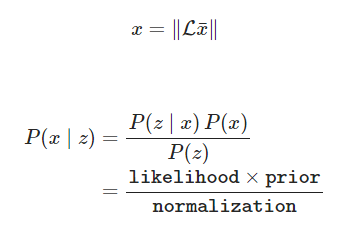

In [5]:
def update_weights(particles,weights,z):
    distance = np.abs(particles-z)
    #Prior X Likelihood
    weights *= stats.norm.pdf(distance)
    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize
    return weights

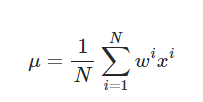

In [6]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""
    mean = np.average(particles, weights=weights, axis=0)
    var  = np.average((particles - mean)**2, weights=weights, axis=0)
    return mean, var

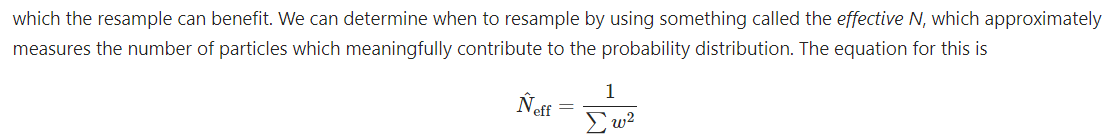

In [7]:
def neff(weights):
    return 1. / np.sum(np.square(weights))

In [8]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    #weights[:] = weights[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

In [9]:
cpi_serie = pd.read_csv(r"..\Datos\cpi_ec.csv",index_col=0)

In [10]:
cpi_serie.columns = ['cpi']
cpi_serie.index = pd.DatetimeIndex(cpi_serie.index)

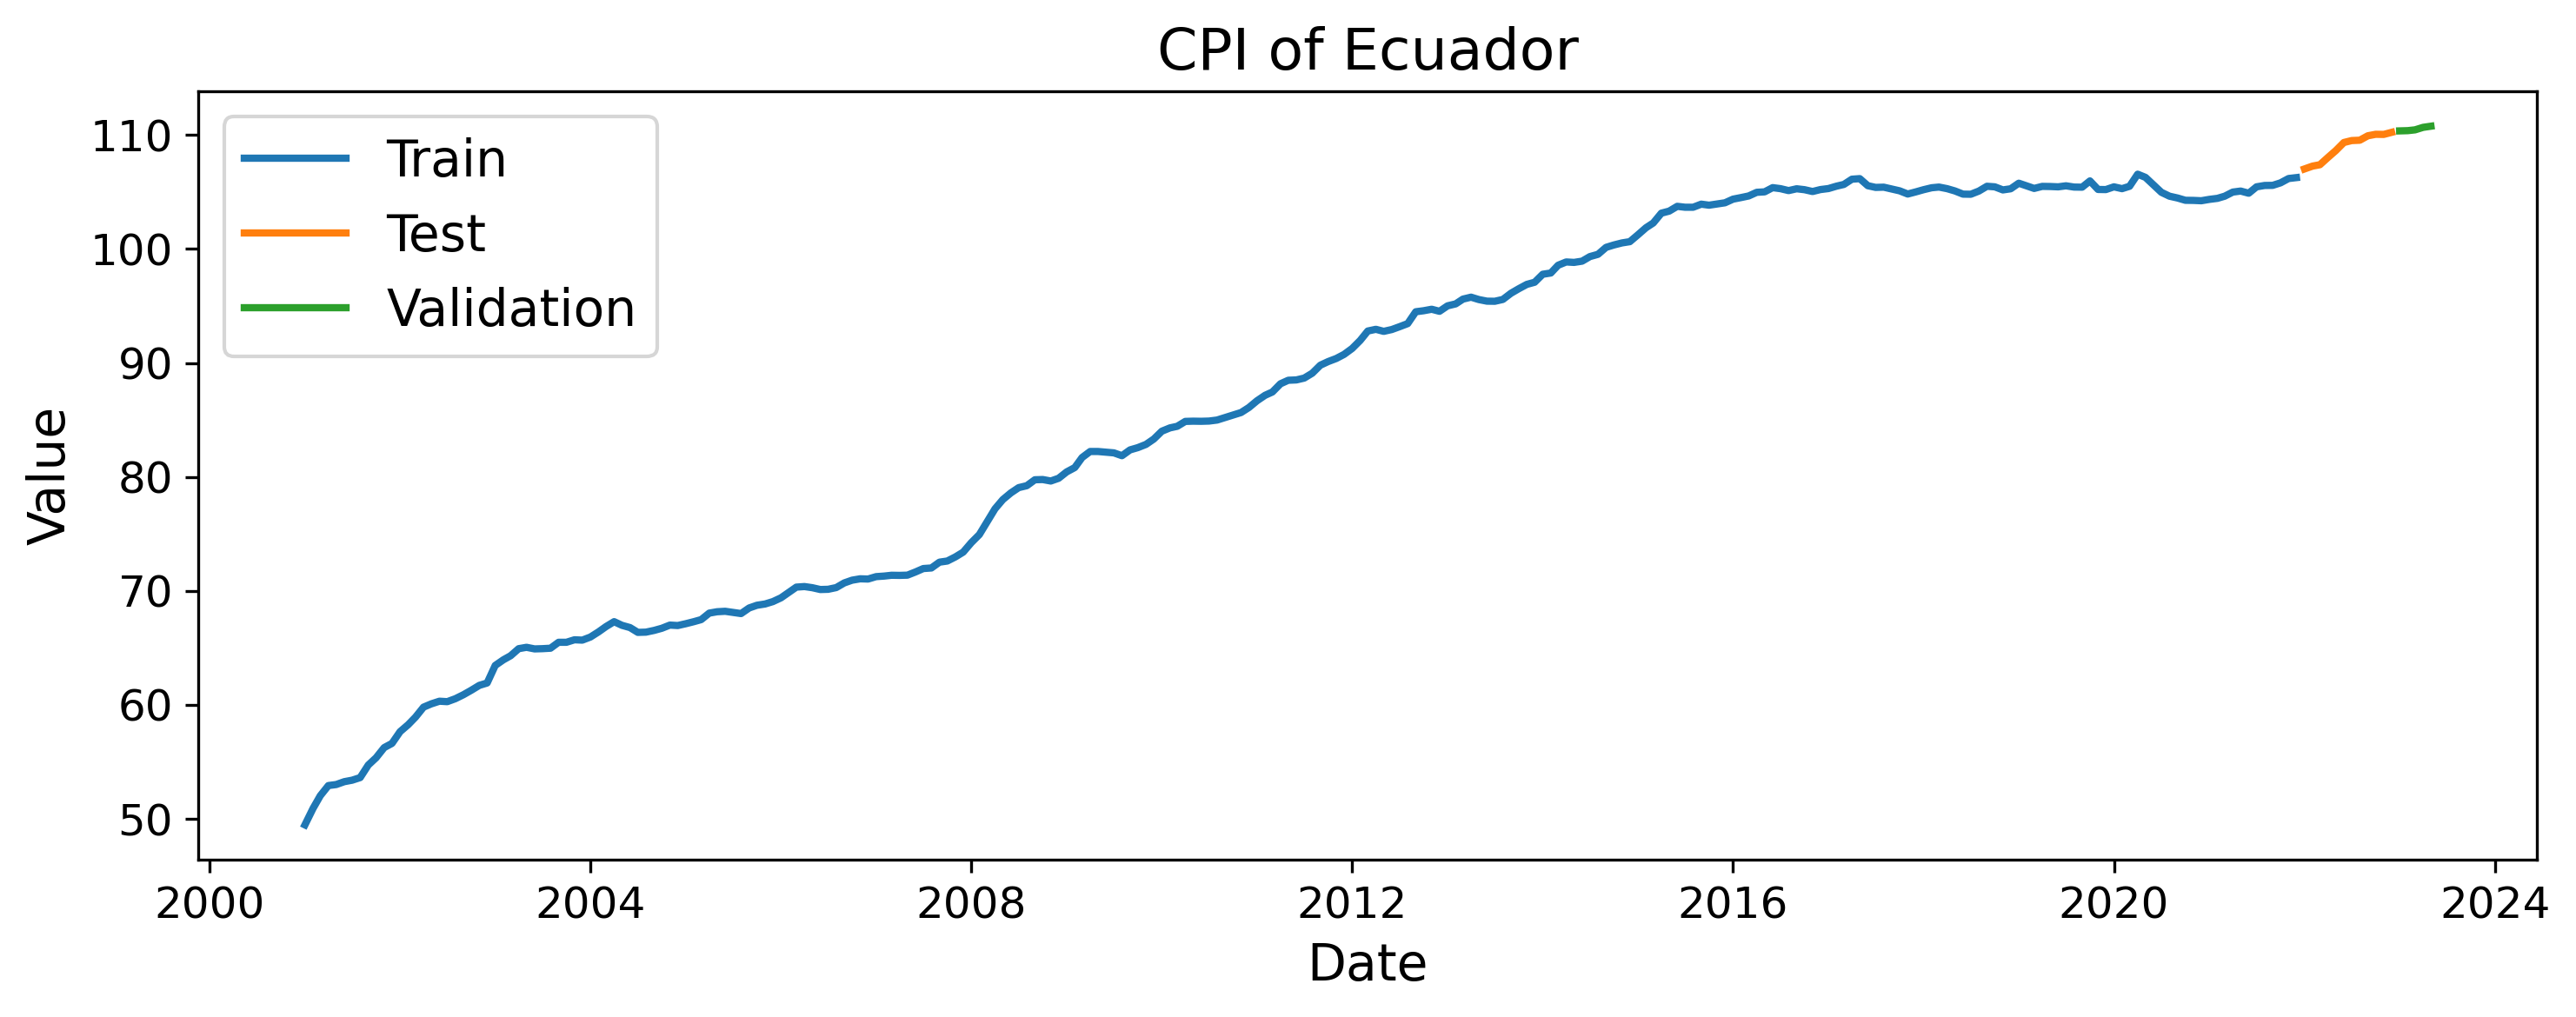

In [11]:
fs = 14
plt.figure(dpi=300, figsize=(10, 4), tight_layout=True)

plt.title('CPI of Ecuador',fontsize=fs+2)
plt.plot(cpi_serie[:-17],label='Train',linewidth=2)
plt.plot(cpi_serie[-17:-5],label='Test',linewidth=2)
plt.plot(cpi_serie[-5:],label='Validation',linewidth=2)
plt.xlabel('Date',fontsize=fs)
plt.ylabel('Value',fontsize=fs)
plt.xticks(fontsize=fs-2)
plt.yticks(fontsize=fs-2)
plt.legend(fontsize=fs)
#plt.savefig('../Figures/cpi_ec.png')

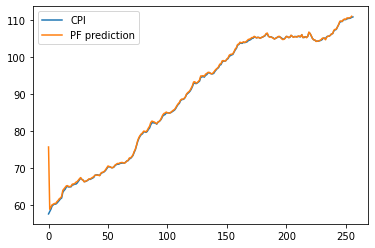

In [12]:
cpi = cpi_serie.reset_index(drop=True)
residuals = [(cpi.iloc[i+1]/cpi.iloc[i]).values for i in range(len(cpi)-1)]
residuals2 = [(cpi.iloc[i+12]/cpi.iloc[i+11]).values for i in range(len(cpi)-12)]
n_test = 12
n_val = 5

train = cpi[12:-(n_test+n_val)]
test = cpi[-(n_test+n_val):-n_val]
val = cpi[-n_val:]

plt.plot(cpi[12:].values,label='CPI')

N = 1000
particles,weights = random_particles(N)

zp = []
zp_t = []
zp_v = []
for i in range(len(train)-1):
    u = ((residuals[i])**(1/2))*residuals2[i]
    u=(u)**(1/2)
    particles = predict(particles,u)
    mu, var = estimate(particles, weights)
    weights = update_weights(particles,weights,train.iloc[i+1].values)

    if neff(weights) < N/2:
        indexes = systematic_resample(weights)
        resample_from_index(particles, weights, indexes)
        assert np.allclose(weights, 1/N) 
    zp.append(mu)

    
    
for i in range(len(test)):
    u = ((residuals[i+len(train)-1]**(1/2)))*(residuals2[i+len(train)-1])
    #u = ((residuals[i+len(train)-1]))*((residuals2[i+len(train)-1]))
    u=(u)**(1/2)
    particles = predict(particles,u)
    mu, var = estimate(particles, weights)
    weights = update_weights(particles,weights,test.iloc[i].values)

    if neff(weights) < N/2:
        indexes = systematic_resample(weights)
        resample_from_index(particles, weights, indexes)
        assert np.allclose(weights, 1/N)  
    zp_t.append(mu)

for i in range(len(val)):
    u = ((residuals[i+len(train)+len(test)-1])**(1/2))*residuals2[i+len(train)+len(test)-1]
    u=(u)**(1/2)
    particles = predict(particles,u)
    mu, var = estimate(particles, weights)
    weights = update_weights(particles,weights,val.iloc[i].values)

    if neff(weights) < N/2:
        indexes = systematic_resample(weights)
        resample_from_index(particles, weights, indexes)
        assert np.allclose(weights, 1/N)  
    zp_v.append(mu)
pred = zp
pred.extend(zp_t)
pred.extend(zp_v)
plt.plot(pred,label='PF prediction')
#plt.plot([len(zp)]*1000,particles)
plt.legend()

In [13]:
print('Train Errors')
x = forecast_accuracy(zp[1:-(n_test+n_val)], train[2:].cpi.tolist())
print(x)
print('Test Errors')
xt = forecast_accuracy(zp_t, test.cpi.tolist())
print(xt)
print('Validation Errors')
xv = forecast_accuracy(zp_v, val.cpi.tolist())
print(xv)

Train Errors
{'mape': 0.002521391196812116, 'me': -0.059521536151289946, 'mae': 0.21832782999012282, 'mpe': -0.0007242882496006054, 'rmse': 0.29649357808149085, 'corr': 0.999832547631568}
Test Errors
{'mape': 0.0026762492579762397, 'me': -0.2208878283471023, 'mae': 0.2906042634826207, 'mpe': -0.0020398008506465133, 'rmse': 0.38322791564851916, 'corr': 0.9747945574037004}
Validation Errors
{'mape': 0.0009218020395245733, 'me': 0.08848434465062667, 'mae': 0.1018962324881187, 'mpe': 0.0008006139322010707, 'rmse': 0.11610795822603284, 'corr': 0.9067461794066508}


In [14]:
score_df = pd.DataFrame(columns=['t-mae','t-mape','t-rmse','v-mae','v-mape','v-rmse'])
sc_ind = []

In [15]:
score_df = score_df.append({'t-mae':xt['mae'],'t-mape':xt['mape'],'t-rmse':xt['rmse'],
                            'v-mae':xv['mae'],'v-mape':xv['mape'],'v-rmse':xv['rmse']},ignore_index=True)
sc_ind.append('PF')

In [16]:
def PF_forecaster(train,N,ptv1,ptv2,steps):
    particles,weights = random_particles(N)
    zp = []
    
    residuals = [(train.iloc[ptv2+i]/train.iloc[ptv2+i-1]).values for i in range(len(train)-ptv2)]
    residuals2 = [(train.iloc[i+1]/train.iloc[i]).values for i in range(len(train)-ptv2)]    
    
    for i in range(len(train)-ptv2-1):
        u = residuals[i]*(residuals2[i])**(1/2)
        u=(u)**(1/2)
        particles = predict(particles,u)
        mu, var = estimate(particles, weights)
        zp.append(mu)
        try:
            weights = update_weights(particles,weights,train.iloc[ptv2+i+1].values)
        except:
            break
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
    
    pred = []
    residuals2 = [(train.iloc[-ptv2+i]/train.iloc[-ptv2+i-1]).values for i in range(ptv2)]    
    
    for i in range(steps):
        if i==0:
            u = (train.iloc[-1]/train.iloc[-2]).values*(residuals2[i])**(1/2)
        elif i==1:
            u = (pred[0]/train.iloc[-1]).values*(residuals2[i])**(1/2)
        else:
            u = (residuals2[i])*(pred[-1]/pred[-2])**(1/2)
        
        u=(u)**(1/2)
        particles = predict(particles,u)
        mu, var = estimate(particles, weights)
        pred.append(mu)
        try:
            weights = update_weights(particles,weights,mu)
        except:
            break
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
            
    
    return zp, pred

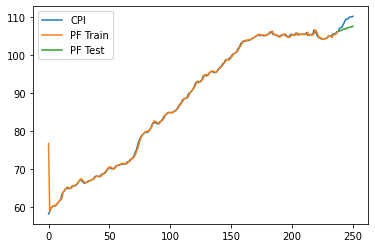

In [17]:
cpi = cpi_serie.reset_index(drop=True)
n_test = 12
n_val = 5

train = cpi[:-(n_test+n_val)]
test = cpi[-(n_test+n_val):-n_val]
val = cpi[-n_val:]
N=1000
zp, pred = PF_forecaster(train,N,1,12,n_test)

plt.plot(cpi[13:-n_val].values,label='CPI')
plt.plot(zp,label='PF Train')
plt.plot(range(len(zp),len(zp)+n_test),pred,label='PF Test')
plt.legend()

In [18]:
xt = forecast_accuracy(pred, test.cpi.tolist())
print(xt)

{'mape': 0.017536666419694005, 'me': -1.9181006321152292, 'mae': 1.9181006321152292, 'mpe': -0.017536666419694005, 'rmse': 2.074733513068012, 'corr': 0.9523867095835694}


{'mape': 0.0032535125577235506, 'me': 0.35989164891051073, 'mae': 0.35989164891051073, 'mpe': 0.0032535125577235506, 'rmse': 0.41782281785530356, 'corr': 0.9791198318245973}


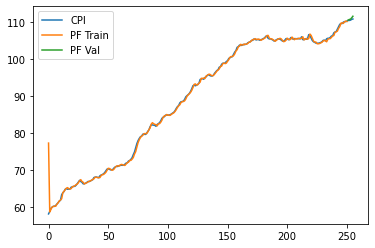

In [19]:
train = cpi[:-n_val]
zp, pred = PF_forecaster(train,N,1,12,n_val)

plt.plot(cpi[13:].values,label='CPI')
plt.plot(zp,label='PF Train')
plt.plot(range(len(zp),len(zp)+n_val),pred,label='PF Val')
plt.legend()

xv = forecast_accuracy(pred, val.cpi.tolist())
print(xv)

In [20]:
score_df = score_df.append({'t-mae':xt['mae'],'t-mape':xt['mape'],'t-rmse':xt['rmse'],
                            'v-mae':xv['mae'],'v-mape':xv['mape'],'v-rmse':xv['rmse']},ignore_index=True)
sc_ind.append('PFF')

In [21]:
score_df.index = sc_ind
score_df

,t-mae,t-mape,t-rmse,v-mae,v-mape,v-rmse
PF,0.290604,0.002676,0.383228,0.101896,0.000922,0.116108
PFF,1.918101,0.017537,2.074734,0.359892,0.003254,0.417823


In [22]:
score_df.to_csv(r'..\Datos\results_PF.csv')